In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model 1

In [ ]:
image_count = 0
labels = []
train_counts = []
for dirname in os.listdir('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/train'):
    labels.append(dirname)
    image_count = 0
    for img in os.listdir(os.path.join('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/train',dirname)):
        image_count +=1
    train_counts.append(image_count)

print(list(zip(train_counts,labels)))

[(354, 'glass'), (286, 'metal'), (403, 'paper'), (287, 'cardboard'), (347, 'plastic'), (91, 'trash')]


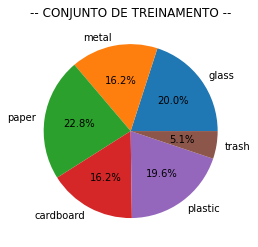

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=labels,
        autopct='%1.1f%%');
plt.title('-- CONJUNTO DE TREINAMENTO --');

In [ ]:
class_weights = []
total_samples = train_generator.samples              #1768
total_classes = len(train_generator.class_indices)   #6
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)
print(dict(zip(labels,class_weights)))

class_weights = dict(zip(train_generator.class_indices.values(),class_weights))

{'glass': 0.83, 'metal': 1.03, 'paper': 0.73, 'cardboard': 1.03, 'plastic': 0.85, 'trash': 3.24}


In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                  )

# Note that the validation data should not be augmented!
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 8 using train_datagen generator
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/train',
                                                    batch_size =8,
                                                    class_mode = 'categorical', 
                                                    target_size = (150,150))     

# Flow validation images in batches of 4 using valid_datagen generator
validation_generator =  valid_datagen.flow_from_directory( '/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/valid',
                                                          batch_size  = 4,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150,150))     

# Flow test images using test_datagen generator
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/test',
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  target_size = (150,150),shuffle = False)     

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

xception_model = keras.applications.InceptionResNetV2(weights="imagenet",
                                                      include_top=False,
                                                      input_shape = (150,150,3))
avg = keras.layers.GlobalAveragePooling2D()(xception_model.output)
output = keras.layers.Dense(6, activation="softmax")(avg)
model = keras.models.Model(inputs=xception_model.input, outputs=output)

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer =optimizer ,loss = 'categorical_crossentropy',metrics =['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.7,patience = 2)
model_checkpoint =tf.keras.callbacks.ModelCheckpoint('GarbageClassifier_Xce.h5', save_best_only=True)

class CustomCallBack(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>0.98):
                print("\nReached 98.0% accuracy so cancelling training!")
                self.model.stop_training = True
                
mycallback = CustomCallBack()

In [ ]:
gpu_name = tf.test.gpu_device_name()
if gpu_name != '/device:GPU:0':
  raise SystemError('no GPUs')
print('GPUs found: {}'.format(gpu_name))

GPUs found: /device:GPU:0


In [ ]:
def train_gpu():
  with tf.device('/device:GPU:0'):
    model_history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs = 50,
            validation_data = validation_generator,
            validation_steps= validation_generator.samples/validation_generator.batch_size)
  return model_history
model_history = train_gpu()

Epoch 1/50
221/221 [==============================] - 46s 137ms/step - loss: 1.4421 - accuracy: 0.4280 - val_loss: 0.8077 - val_accuracy: 0.6921
Epoch 2/50
221/221 [==============================] - 28s 126ms/step - loss: 0.8338 - accuracy: 0.7098 - val_loss: 0.4857 - val_accuracy: 0.8476
Epoch 3/50
221/221 [==============================] - 27s 124ms/step - loss: 0.5966 - accuracy: 0.7962 - val_loss: 0.4825 - val_accuracy: 0.8689
Epoch 4/50
221/221 [==============================] - 27s 124ms/step - loss: 0.4532 - accuracy: 0.8345 - val_loss: 1.1315 - val_accuracy: 0.8384
Epoch 5/50
221/221 [==============================] - 27s 124ms/step - loss: 0.4146 - accuracy: 0.8547 - val_loss: 0.6693 - val_accuracy: 0.8994
Epoch 6/50
221/221 [==============================] - 27s 123ms/step - loss: 0.3646 - accuracy: 0.8875 - val_loss: 1.1825 - val_accuracy: 0.8506
Epoch 7/50
221/221 [==============================] - 27s 122ms/step - loss: 0.2983 - accuracy: 0.8980 - val_loss: 2.1407 - val_ac

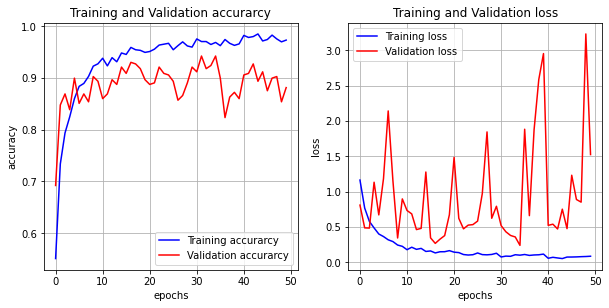

In [ ]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(model_history.history['accuracy'],'b-', label = "Training accurarcy")
plt.plot(model_history.history['val_accuracy'], 'r-', label = "Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(model_history.history['loss'],'b-', label = "Training loss")
plt.plot(model_history.history['val_loss'], 'r-', label = "Validation loss")
plt.title("Training and Validation loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()



In [ ]:
model.evaluate(test_generator,batch_size = 1) 

431/431 [==============================] - 12s 27ms/step - loss: 0.9072 - accuracy: 0.8910


[0.907233715057373, 0.8909512758255005]

              precision    recall  f1-score   support

           0       0.95      0.90      0.93        70
           1       0.97      0.78      0.86        82
           2       0.83      0.94      0.88        68
           3       0.90      0.95      0.92       108
           4       0.83      0.91      0.86        74
           5       0.88      0.79      0.84        29

    accuracy                           0.89       431
   macro avg       0.89      0.88      0.88       431
weighted avg       0.90      0.89      0.89       431



Text(0.5, 1.0, 'Confusion matrix of model')

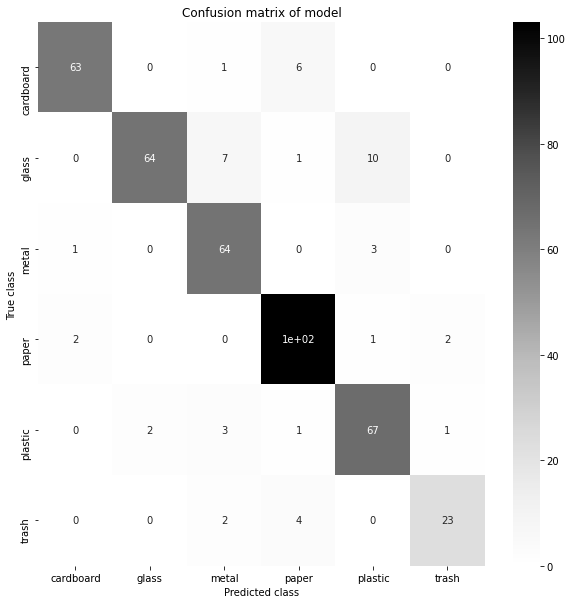

In [ ]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), annot=True, cmap="Greys")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

# MODEL 2

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

xception_model = keras.applications.xception.Xception(weights="imagenet",
                                                      include_top=False,
                                                      input_shape = (150,150,3))
avg = keras.layers.GlobalAveragePooling2D()(xception_model.output)
output = keras.layers.Dense(6, activation="softmax")(avg)
model2 = keras.models.Model(inputs=xception_model.input, outputs=output)

83689472/83683744 [==============================] - 2s 0us/step


In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
model2.compile(optimizer =optimizer ,loss = 'categorical_crossentropy',metrics =['accuracy'])

In [ ]:
def train_gpu():
  with tf.device('/device:GPU:0'):
    model1_history = model2.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs = 50,
            validation_data = validation_generator,
            validation_steps= validation_generator.samples/validation_generator.batch_size)
  return model1_history
model1_history = train_gpu()

Epoch 1/50
221/221 [==============================] - 28s 109ms/step - loss: 1.4068 - accuracy: 0.4704 - val_loss: 4.4622 - val_accuracy: 0.2927
Epoch 2/50
221/221 [==============================] - 23s 104ms/step - loss: 1.1200 - accuracy: 0.5828 - val_loss: 0.8673 - val_accuracy: 0.7073
Epoch 3/50
221/221 [==============================] - 24s 106ms/step - loss: 1.0243 - accuracy: 0.6264 - val_loss: 0.9029 - val_accuracy: 0.6646
Epoch 4/50
221/221 [==============================] - 24s 107ms/step - loss: 0.8828 - accuracy: 0.6720 - val_loss: 0.9862 - val_accuracy: 0.6921
Epoch 5/50
221/221 [==============================] - 24s 107ms/step - loss: 0.8084 - accuracy: 0.7172 - val_loss: 3.7937 - val_accuracy: 0.3476
Epoch 6/50
221/221 [==============================] - 24s 107ms/step - loss: 0.8225 - accuracy: 0.7200 - val_loss: 1.5619 - val_accuracy: 0.5518
Epoch 7/50
221/221 [==============================] - 24s 107ms/step - loss: 0.7415 - accuracy: 0.7365 - val_loss: 1.1468 - val_ac

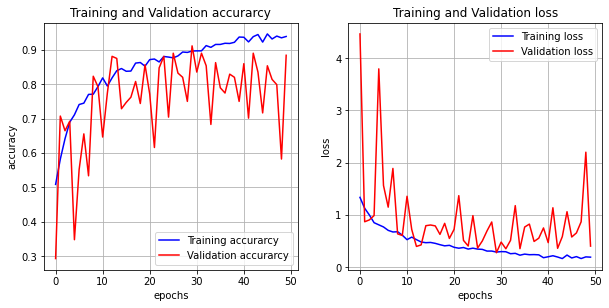

In [ ]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(model1_history.history['accuracy'],'b-', label = "Training accurarcy")
plt.plot(model1_history.history['val_accuracy'], 'r-', label = "Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(model1_history.history['loss'],'b-', label = "Training loss")
plt.plot(model1_history.history['val_loss'], 'r-', label = "Validation loss")
plt.title("Training and Validation loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()


In [ ]:
model2.evaluate(test_generator,batch_size = 1)

431/431 [==============================] - 4s 8ms/step - loss: 0.4948 - accuracy: 0.8492


[0.4948113262653351, 0.8491879105567932]

In [ ]:
test_generator.class_indices.keys()

dict_keys(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        70
           1       0.93      0.78      0.85        82
           2       0.74      0.96      0.83        68
           3       0.95      0.75      0.84       108
           4       0.86      0.82      0.84        74
           5       0.80      0.97      0.88        29

    accuracy                           0.85       431
   macro avg       0.85      0.87      0.85       431
weighted avg       0.86      0.85      0.85       431



Text(0.5, 1.0, 'Confusion matrix of model')

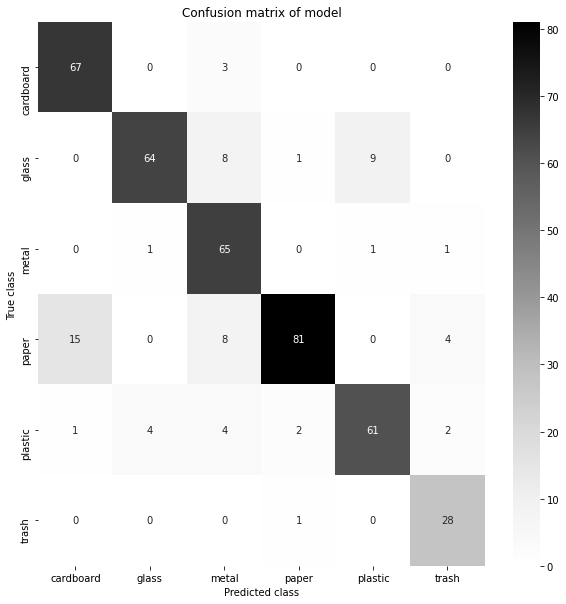

In [ ]:
y_pred = model2.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), annot=True, cmap="Greys")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

# Modelo 3